In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
from tqdm import tqdm

from src.data import DataLoader
from src.helpers import (
    calculate_ats_performance,
    calculate_seasonal_accuracy,
    calculate_spread_percentile,
    load_all_predictions,
)
from src.paths import PREDICTION_DIR

# Data

In [2]:
game_data = DataLoader(2015, 2025).data

prediction_data = load_all_predictions(PREDICTION_DIR)

data = pd.merge(
    game_data,
    prediction_data,
    on=["season", "week", "home_team", "away_team"],
    how="inner",
).dropna(subset=["result"])

# Methodology

For each game we identify where the spread falls within the model's predicted distribution. This is done by finding the percentile index (*spread_idx*) such that:

$$
spread\_idx = P(\text{Predicted Score Differential} \leq \text{Spread})
$$

Intuitively:
- A *spread_idx* near **50** means the spread closely matches the model's expectation.
- A *spread_idx* near **0** or **100** means the spread is far from what the model predicts--suggesting a potential market inefficiency.

The following figure illustrates this concept. The blue curve represents the model's predicted distribution of score differentials, and the dashed red line shows where the actual spread lies within that distribution.

In this example, the spread lies far to the right of the model’s expected distribution (*spread_idx = 84*). This indicates that the market may be overestimating the home team’s advantage, and the model would favor a bet on the away team.

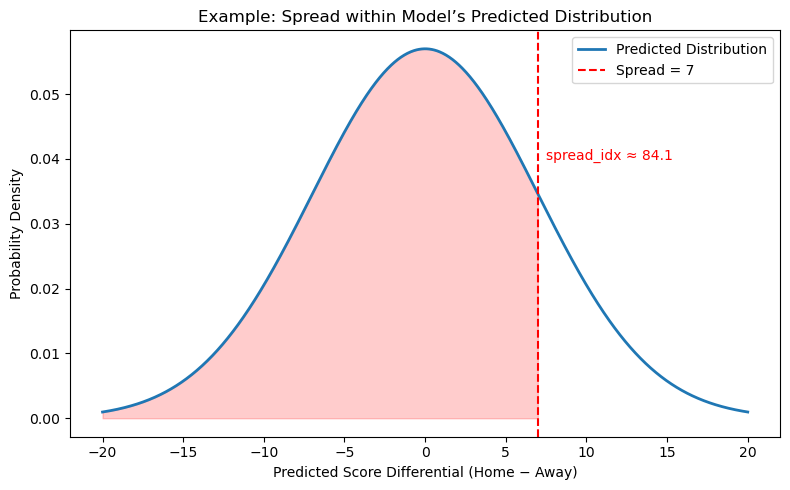

In [3]:
x = np.linspace(-20, 20, 1000)
mean, std = 0, 7
pdf = norm.pdf(x, mean, std)
spread = 7

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label="Predicted Distribution", lw=2)
plt.axvline(
    spread,
    color="red",
    linestyle="--",
    label=f"Spread = {spread}",
)
plt.fill_between(x, 0, pdf, where=(x <= spread), color="red", alpha=0.2)
percentile = norm.cdf(spread, mean, std) * 100
plt.text(spread + 0.5, max(pdf) * 0.7, f"spread_idx ≈ {percentile:.1f}", color="red")
plt.title("Example: Spread within Model’s Predicted Distribution")
plt.xlabel("Predicted Score Differential (Home − Away)")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout()
plt.show()

To express the *spread_idx* in a more intuitive way, we define:

$$
confidence = \frac{|spread\_idx - 50|}{50}
$$

Values range from **0 (uncertain)** to **1 (confident)**. For example, a *spread_idx* of 80 or 20 would yield a confidence of 0.6 (or 60% confident). This metric allows us to summarize how "sure" the model is about each prediction while maintaining interpretability.

To test whether this confidence translates into practical value, we simulate a simple betting strategy:

- Define a **minimum confidence threshold** (e.g., 0.5, 0.6, 0.7). Only games where the model's confidence exceeds this threshold are considered for betting.
- For each qualifying game:
  - Bet on the **away team** if `spread_idx > 50`
  - Bet on the **home team** if `spread_idx < 50`
- Determine wins and losses by comparing the actual game result to the spread in the predicted direction.

# Results

In [4]:
# Store spread_idx and confidence
for line, spread_col in [("close", "spread_line"), ("open", "spread_line_open")]:
    data[f"spread_idx_{line}"] = data.apply(
        lambda row: (
            calculate_spread_percentile(row, spread_col)
            if pd.notna(row[spread_col])
            else np.nan
        ),
        axis=1,
    )
    data[f"confidence_{line}"] = (data[f"spread_idx_{line}"] - 50).abs() / 50

# Simulation results
results = {}

all_seasons = list(data["season"].unique())
confidence_thresholds = np.linspace(0, 1, 101)

for threshold in tqdm(confidence_thresholds):
    out_df = calculate_ats_performance(data, threshold)
    out_df = calculate_seasonal_accuracy(out_df).set_index("season")
    results[threshold] = {}

    for season in ["overall"] + all_seasons:
        results[threshold][season] = {
            "bets_placed_close": out_df.loc[season, "bets_placed_close"],
            "bets_won_close": out_df.loc[season, "bets_won_close"],
            "bets_placed_open": out_df.loc[season, "bets_placed_open"],
            "bets_won_open": out_df.loc[season, "bets_won_open"],
            "accuracy_close": out_df.loc[season, "accuracy_close"],
            "accuracy_open": out_df.loc[season, "accuracy_open"],
        }

100%|██████████| 101/101 [01:54<00:00,  1.13s/it]


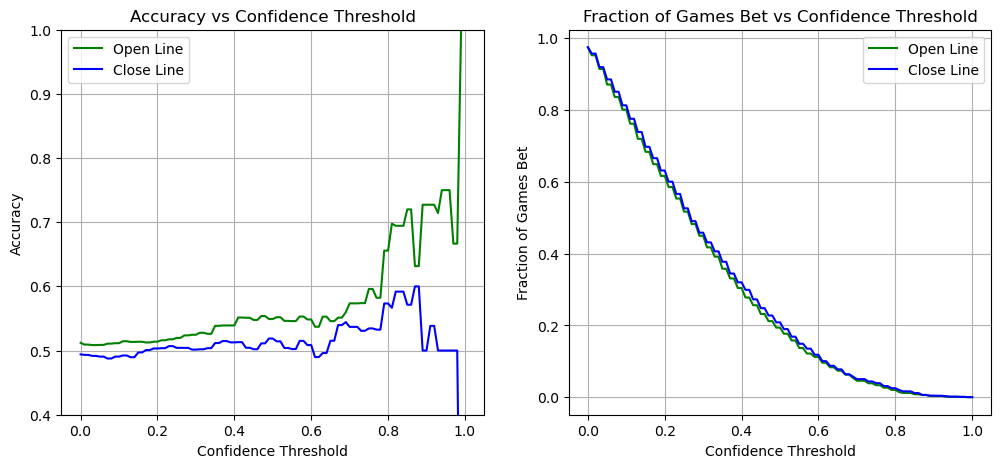

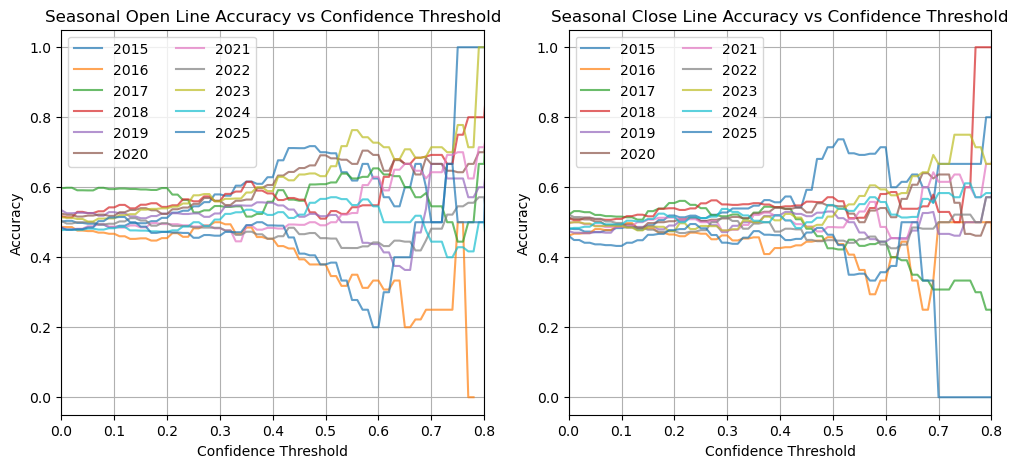

In [5]:
# Figures 1 & 2: Accuracy vs Confidence & Fraction of Bets vs Confidence
conf_thresh = list(results.keys())
open_accuracy = [i["overall"]["accuracy_open"] for i in results.values()]
close_accuracy = [i["overall"]["accuracy_close"] for i in results.values()]
open_bet_pctg = [i["overall"]["bets_placed_open"] / len(data) for i in results.values()]
close_bet_pctg = [
    i["overall"]["bets_placed_close"] / len(data) for i in results.values()
]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(conf_thresh, open_accuracy, color="green", label="Open Line")
plt.plot(conf_thresh, close_accuracy, color="blue", label="Close Line")
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Confidence Threshold")
plt.grid(True)
plt.ylim(0.4, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(conf_thresh, open_bet_pctg, color="green", label="Open Line")
plt.plot(conf_thresh, close_bet_pctg, color="blue", label="Close Line")
plt.xlabel("Confidence Threshold")
plt.ylabel("Fraction of Games Bet")
plt.title("Fraction of Games Bet vs Confidence Threshold")
plt.grid(True)
plt.legend()

plt.show()

# Figures 3 & 4: Seasonal Open & Close Line Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for season in all_seasons:
    open_accuracy_season = [i[season]["accuracy_open"] for i in results.values()]
    plt.plot(conf_thresh, open_accuracy_season, label=f"{season}", alpha=0.7)
plt.xlim(0.0, 0.8)
plt.grid(True)
plt.legend(ncol=2, loc="upper left")
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Seasonal Open Line Accuracy vs Confidence Threshold")

plt.subplot(1, 2, 2)
for season in all_seasons:
    close_accuracy_season = [i[season]["accuracy_close"] for i in results.values()]
    plt.plot(conf_thresh, close_accuracy_season, label=f"{season}", alpha=0.7)
plt.xlim(0.0, 0.8)
plt.grid(True)
plt.legend(ncol=2, loc="upper left")
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Seasonal Close Line Accuracy vs Confidence Threshold")

plt.show()

# Threshold Selection

As seen in the previous section, the overall trend shows higher confidence thresholds correspond to higher accuracy, but individual seasons can still perform badly. This occurs because bets become rarer as the confidence threshold increases, meaning we introduce more variance into season-by-season performance. To understand and mitigate this variance, first let's take a probabilistic view of why losing seasons are expected, even with a true edge.

We can formalize this using the Binomial distribution. Assume at a 60% confidence threshold against the opening spread we have a true edge of **p = 0.55**. Let **n** be the number of bets placed in a season (around 30 bets per season at this confidence threshold),  and let **W ~ Binomial(n, p)** represent the number of observed wins. Then there is a 23% probability of a losing season:

$$
P(W < 15) = \sum_{k=0}^{14} \binom{30}{k} 0.55^k \cdot 0.45^{30-k} = 0.23
$$

The binomial example shows that even a strategy with a true edge can have losing seasons simply due to variance--especially when the number of bets is small. This is exactly why choosing the right confidence threshold matters. To pick a threshold that is both profitable and stable, we evaluate each threshold based on total profit and loss, as well as expected ROI per bet using bootstrapped confidence intervals. The next section plots these metrics to highlight where the model performs most reliably.

In [6]:
def calculate_game_pnl(row: pd.Series, spread_col: str) -> float:
    """Calculate profit / loss from results data.

    Args:
        row: A game of the results data.
        spread_col: Spread type, either 'close' or 'open'.

    Returns:
        A float of the profit / loss.
    """
    if row[f"bets_placed_{spread_col}"] == 0:
        return 0.0
    if row[f"bets_won_{spread_col}"] == 1:
        return 100 / 110
    else:
        return -1.0

In [7]:
threshold_results = []
confidence_thresholds = np.linspace(0, 1, 101)

for threshold in tqdm(confidence_thresholds):

    out_df = calculate_ats_performance(data, threshold)
    out_results = {"threshold": threshold}

    for spread_col in ["close", "open"]:
        # P&L
        pnl_values = out_df.apply(
            lambda row: calculate_game_pnl(row, spread_col), axis=1
        )
        boot_sums = []
        for _ in range(10000):
            sample = np.random.choice(pnl_values, size=len(pnl_values), replace=True)
            boot_sums.append(sample.sum())
        pnl_mean = np.mean(boot_sums)
        pnl_low = np.percentile(boot_sums, 2.5)
        pnl_high = np.percentile(boot_sums, 97.5)

        # ROI
        roi_mask = out_df[f"bets_placed_{spread_col}"] == 1
        roi_values = pnl_values[roi_mask]
        boot_means = []
        for _ in range(10000):
            sample = np.random.choice(roi_values, size=len(roi_values), replace=True)
            boot_means.append(sample.mean())
        roi_mean = np.mean(boot_means)
        roi_low = np.percentile(boot_means, 2.5)
        roi_high = np.percentile(boot_means, 97.5)

        # Save results
        out_results[f"{spread_col}_pnl_mean"] = pnl_mean
        out_results[f"{spread_col}_pnl_low"] = pnl_low
        out_results[f"{spread_col}_pnl_high"] = pnl_high
        out_results[f"{spread_col}_roi_mean"] = roi_mean
        out_results[f"{spread_col}_roi_low"] = roi_low
        out_results[f"{spread_col}_roi_high"] = roi_high

    threshold_results.append(out_results)

threshold_results = pd.DataFrame(threshold_results)

100%|██████████| 101/101 [04:40<00:00,  2.78s/it]


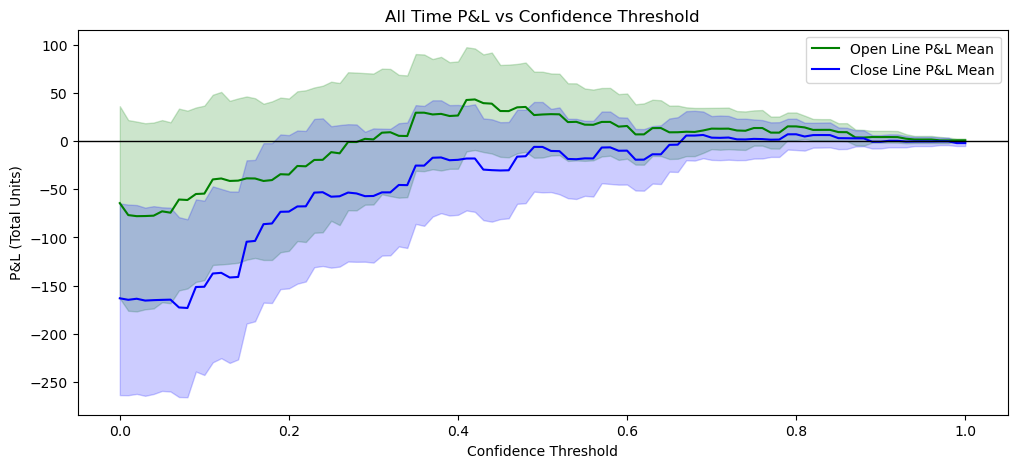

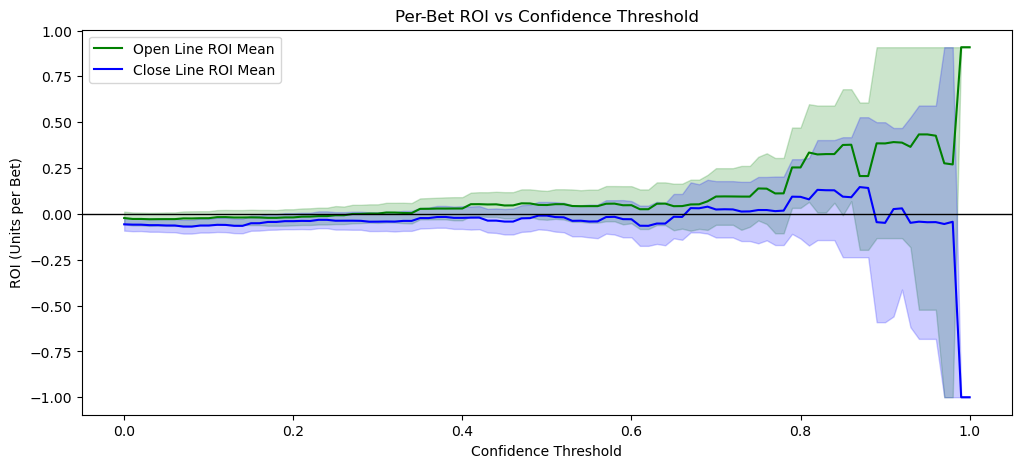

In [8]:
# Figure 5: P&L vs Confidence Threshold
plt.figure(figsize=(12, 5))
plt.plot(
    threshold_results["threshold"],
    threshold_results["open_pnl_mean"],
    label="Open Line P&L Mean",
    color="green",
)
plt.fill_between(
    threshold_results["threshold"],
    threshold_results["open_pnl_low"],
    threshold_results["open_pnl_high"],
    color="green",
    alpha=0.2,
)
plt.plot(
    threshold_results["threshold"],
    threshold_results["close_pnl_mean"],
    label="Close Line P&L Mean",
    color="blue",
)
plt.fill_between(
    threshold_results["threshold"],
    threshold_results["close_pnl_low"],
    threshold_results["close_pnl_high"],
    color="blue",
    alpha=0.2,
)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Confidence Threshold")
plt.ylabel("P&L (Total Units)")
plt.title("All Time P&L vs Confidence Threshold")
plt.legend()
plt.show()

# Figure 6: ROI vs Confidence Threshold
plt.figure(figsize=(12, 5))
plt.plot(
    threshold_results["threshold"],
    threshold_results["open_roi_mean"],
    label="Open Line ROI Mean",
    color="green",
)
plt.fill_between(
    threshold_results["threshold"],
    threshold_results["open_roi_low"],
    threshold_results["open_roi_high"],
    color="green",
    alpha=0.2,
)
plt.plot(
    threshold_results["threshold"],
    threshold_results["close_roi_mean"],
    label="Close Line ROI Mean",
    color="blue",
)
plt.fill_between(
    threshold_results["threshold"],
    threshold_results["close_roi_low"],
    threshold_results["close_roi_high"],
    color="blue",
    alpha=0.2,
)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Confidence Threshold")
plt.ylabel("ROI (Units per Bet)")
plt.title("Per-Bet ROI vs Confidence Threshold")
plt.legend()
plt.show()

# Future Work

As seen in the figures above, even though the model demonstrates increasing accuracy at higher confidence thresholds, this does not directly translate into consistent profitability. Once we account for the vig and sampling uncertainty, only a narrow band of thresholds show positive P&L and ROI at the 95% confidence level. Based on this analysis, the most practical operating range appears to be high confidence thresholds **(> 0.75)** against the opening line. The next step is to improve the model such that the profitable region widens and the confidence intervals shrink. In this section we outline several ways to increase the model's predictive signal.

### Contextual Home Field Advantage

A key area for improvement is refining the model's treatment of home-field advantage. Currently, the model assumes a single global home-field effect, but in reality the advantage varies meaningfully with context such as rest disparities, divisional familiarity, weather and surface changes, and game importance. Even a simple OLS regression illustrates this point: after controlling for the model's prediction, rest advantage alone has a statistically significant impact.

In [9]:
X = data[["prediction_mean", "rest_advantage"]]
X = sm.add_constant(X)
y = data["result"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     269.7
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          3.11e-108
Time:                        09:13:05   Log-Likelihood:                -11699.
No. Observations:                2937   AIC:                         2.340e+04
Df Residuals:                    2934   BIC:                         2.342e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0105      0.254     -0.041      0.967      -0.509       0.488
prediction_mean     0.9806      0.043     23.067      0.000       0.897       1.064
rest_advantage      0.3027      0.139      2.177      0.030       0.030       0.575
==============================================================================
Omnibus:                       13.659   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.773
Skew:                           0.076   Prob(JB):                     0.000228
Kurtosis:                       3.337   Cond. No.                         6.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Quarterback Effect Modeling

The current model calculates quarterback effects as static values using data from the past five years. This approach has two limitations. First, it does not account for the dynamic nature of quarterback performance over time, which likely fluctuates like team effects. Second, due to the Bayesian shrinkage in our model, quarterbacks with few games are pulled heavily toward the average, which may overestimate their true ability. To illustrate this, we created flags for whether the home or away quarterback had played fewer than a full season and ran a simple OLS regression. The results strongly suggest our current approach may misrepresent the effect of quarterbacks with limited playing history, and future work should explore dynamic modeling or alternative priors to better capture these effects.

In [10]:
df = data.copy()

home_qb = (
    df[["home_qb_name"]]
    .rename(columns={"home_qb_name": "qb"})
    .reset_index()
    .assign(side="home")
)
away_qb = (
    df[["away_qb_name"]]
    .rename(columns={"away_qb_name": "qb"})
    .reset_index()
    .assign(side="away")
)
long_qb = pd.concat([home_qb, away_qb], ignore_index=True)
long_qb = long_qb.sort_values(["index", "side"]).reset_index(drop=True)
long_qb["career_games_to_date"] = long_qb.groupby("qb").cumcount()
home_counts = (
    long_qb[long_qb["side"] == "home"].sort_values("index").reset_index(drop=True)
)
away_counts = (
    long_qb[long_qb["side"] == "away"].sort_values("index").reset_index(drop=True)
)

df["home_qb_limited_games"] = (home_counts["career_games_to_date"] < 16).astype(int)
df["away_qb_limited_games"] = (away_counts["career_games_to_date"] < 16).astype(int)
df = df[df["season"] >= 2020]

X = df[["prediction_mean", "home_qb_limited_games", "away_qb_limited_games"]]
X = sm.add_constant(X)
y = df["result"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     100.1
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           2.33e-59
Time:                        09:13:05   Log-Likelihood:                -6378.2
No. Observations:                1602   AIC:                         1.276e+04
Df Residuals:                    1598   BIC:                         1.279e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2763      0.420      0.659      0.510      -0.547       1.099
prediction_mean           0.8992      0.060     14.870      0.000       0.781       1.018
home_qb_limited_games    -1.6059      0.806     -1.991      0.047      -3.188      -0.024
away_qb_limited_games     2.3026      0.801      2.874      0.004       0.731       3.874
==============================================================================
Omnibus:                        6.839   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.563
Skew:                           0.094   Prob(JB):                       0.0228
Kurtosis:                       3.279   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Alternative Modeling Approaches

Several extensions to the current framework could be explored to improve predictive performance. One line of work refines the original model by applying data transformations to the outcome variable (observed point differential). The motivation behind these approaches is to reduce the influence of large victory margins, which carry little predictive information late in a game when trailing teams rest key players. These transformations can potentially help the model focus on meaningful differences in game outcomes rather than extreme, potentially noisy results.

Another potential improvement is to reconsider the outcome variable. Instead of modeling observed point differentials, efficiency-based metrics such as Expected Points Added (EPA) or Win Probability Added (WPA) could provide a more granular measure of team and quarterback performance.